In [2]:
import os
import shutil
import seaborn as sns
import pandas as pd
import numpy as np
import math
import openpyxl
import csv
import pprint
from scipy import stats
from scipy.stats import norm
from scipy import optimize as opt
from scipy.optimize import Bounds
import matplotlib.pyplot as plt
import matplotlib as mpl
import japanize_matplotlib #日本語を表示
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_Interactivity="all"

sns.set(font="IPAexGothic")#日本語を表示

%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/Users/ryo/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
#os.chdir("..")#一つ上のディレクトリへ
os.getcwd()

'/Users/ryo/Google ドライブ/明坂/2021/GCOE/Code'

# Pathの設定

In [20]:
dir_path='../20210608'
data_path='../20210608/Data_sphinx.xlsx'

# データの読み込み

In [21]:
調査年度一覧=pd.read_excel(data_path, dtype=object,sheet_name=None, na_values=(''),skipinitialspace=True,header=0)    
sheet_name=調査年度一覧.keys()
sheet_name

odict_keys(['五段階心理的質問', '時間割引率', 'リスク選好', '利他性', '相対的評価', '基本属性', '学生時代', '家族', '子供', '遺産相続', '将来予測', '消費計画', '健康管理', '生活習慣', '宗教', '就業', '資産', 'その他'])

# 問題番号の振り直し

In [22]:
Data_new = pd.ExcelWriter(dir_path+"/" +"Data_new_問題番号振り直し.xlsx")    
for daimon in  調査年度一覧.keys():
    Daimon=調査年度一覧[daimon]
    n=1
    for q_num in list(Daimon["問題番号"].unique()):
        tmp=Daimon[Daimon["問題番号"]==q_num].index 
        Daimon.loc[tmp,"問題番号"]=n
        n=n+1
    調査年度一覧[daimon]=Daimon
    Daimon.to_excel(Data_new, index=False,sheet_name= daimon)

# エクセルファイルを保存
Data_new.save()    

# データ確認作業

In [23]:
調査年度一覧=pd.read_excel(dir_path+"/" +"Data_new_問題番号振り直し.xlsx" , dtype=object,sheet_name=None, na_values=(''),skipinitialspace=True,header=0)    
#　１つのデータフレーム (Data_list) に
Data_list = pd.DataFrame()
for daimon in  調査年度一覧.keys():
    Data_list = pd.concat([Data_list, 調査年度一覧[daimon]])

Year=[2005,2006,2007,2008,2009,2010,2011,2012,2013,2016,2017,2018]
Year_row=["X"+str(year)+"年"  for year in Year]

#2012年度の生データが順序ぐちゃぐちゃなので加工（手作業）
year=2012
#生データの読み込み
path="../../../Japan_Mikami/"+str(year)+"/Data/Excel format/"+str(year)+"Data_JAPAN_cityid.csv"
Row_data = pd.read_csv(path, encoding='UTF-8')
Names=Row_data.columns
Names_2012=list(Names[0:39])+list(Names[84:110])+list(Names[144:153])+list(Names[177:226])+list(Names[39:84])+list(Names[110:139])+list(Names[226:232])+list(Names[139:144])+list(Names[153:177])+list(Names[232:])

年度別調査項目 = pd.ExcelWriter(dir_path+"/" +"年度別調査項目.xlsx")    
Data_dict=dict()
未確認変数 = pd.ExcelWriter(dir_path+"/" +"未確認変数.xlsx")    
List_NA=dict()
for year in Year:
    if year!= 2020:
        #生データの読み込み
        path="../../../Japan_Mikami/"+str(year)+"/Data/Excel format/"+str(year)+"Data_JAPAN_cityid.csv"
        Row_data = pd.read_csv(path, encoding='UTF-8')
        Names=Row_data.columns
        #.xls形式で保存した生データのフォーマット        
        path="../Input/Format/"+str(year)+" Data Format_JAPAN.xls"
        Format=pd.read_excel(path, dtype=object, index_col=0)    
        Format["列名"]=Names
        if year==2012:
            Format["列名"]=Names_2012
    
    if year== 2020:
        #生データの読み込み        
        path="../input/社研パネル2020/2020年度くら好_data2021年3月.csv"
        Row_data = pd.read_csv(path, encoding='UTF-8')
        Names=Row_data.columns
        #.xls形式で保存した生データのフォーマット        
        path="../Input/社研パネル2020/2020年度くら好_datafmt2021年3月.xls"
        Format=pd.read_excel(path, dtype=object, index_col=0)    
        Format["列名"]=Names
        
    #年別のData_list
    tmp=Data_list[~Data_list["X"+str(year)+"年" ].isnull()]
    Q_list=tmp.loc[:,["大問区分","小問区分","質問対象者","問題番号","階層","問題文","問題文2","問題文3","選択肢", "X"+str(year)+"年"]]
    tmp=pd.merge(Format, Q_list,left_on=["列名"], right_on=["X"+str(year)+"年"],how="left") 
    tmp["調査年度"]=year
    sheet_name=str(year)+"_Data_JAPAN_cityid"
    tmp.to_excel(年度別調査項目, index=False,sheet_name= sheet_name)
    Data_dict.update({sheet_name:tmp})
    
    list_NA=tmp[tmp["大問区分"].isnull()]
    list_NA.to_excel(未確認変数, index=False,sheet_name= sheet_name)
    List_NA.update({sheet_name:list_NA})

# エクセルファイルを保存
年度別調査項目.save()    
未確認変数.save()        



Cheack = pd.DataFrame()
for year in  Year:
    tmp=Data_list[~Data_list["X"+str(year)+"年"].isnull()]
    tmp=tmp[tmp.duplicated("X"+str(year)+"年", keep=False)]
    Cheack = pd.concat([Cheack, tmp])
    
Cheack_list = pd.ExcelWriter(dir_path+"/" +"重複_Cheack_list.xlsx") 
Cheack.to_excel(Cheack_list, index=False)

# エクセルファイルを保存
Cheack_list.save()    


# 調査項目一覧(確認用)

In [34]:
調査年度一覧=pd.read_excel(dir_path+"/" +"Data_new_問題番号振り直し.xlsx" , dtype=object,sheet_name=None, na_values=(''),skipinitialspace=True,header=0)    

sheet_name=調査年度一覧.keys()
問題一覧= pd.ExcelWriter(dir_path+"/" +"問題一覧(確認用).xlsx")    
for daimon in  調査年度一覧.keys():
    Daimon=調査年度一覧[daimon]
    Daimon=Daimon[~Daimon.duplicated("問題番号")]
    
    Daimon[["大問区分","小問区分","問題番号","階層","問題文"]].to_excel(問題一覧, index=False,sheet_name= daimon)
    
# エクセルファイルを保存
問題一覧.save()    

問題一覧=pd.read_excel(dir_path+"/" +"調査項目一覧(確認用).xlsx", dtype=object,sheet_name=None, na_values=(''),skipinitialspace=True,header=0)    

# Html ビルド

In [ ]:
調査年度一覧=pd.read_excel(dir_path+"/" +"Data_new_問題番号振り直し.xlsx" , dtype=object,sheet_name=None, na_values=(''),skipinitialspace=True,header=0)    
shutil.rmtree("../txt") # txtフォルダをクリア
new_dir_path = '../txt'
os.mkdir(new_dir_path)


Year=[2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2016,2017,2018,2020]
Year_row=["X"+str(year)+"年"  for year in Year]

for daimon in  調査年度一覧.keys():
    Daimon=調査年度一覧[daimon]
    new_dir_path ="../txt/"+daimon
    os.mkdir(new_dir_path)
    for syoumon in list(set(Daimon["小問区分"])) :
        new_dir_path ="../txt/"+daimon+"/"+syoumon
        os.mkdir(new_dir_path)
    
#     df.loc[:,["問題文2","問題文3","選択肢"]+Year_row].to_csv('tmp.csv', encoding='utf_8_sig')
    for q_num in Daimon["問題番号"].unique():
        df=Daimon[Daimon["問題番号"]==q_num] 
        df=df.reset_index()
        
        問題文=df["問題文"][0]
        
        全文=df["問題文"].fillna("")+str("\n")+df["問題文2"].fillna("")+str("\n")+df["問題文3"].fillna("")
        全文='\n'.join(全文.values)
        問題文2='\n'.join(df["問題文2"].fillna(""))

        階層=list(set(df["階層"]))
        小問区分=df["小問区分"][0]
        質問対象者=set(df["質問対象者"].unique()) 
        選択肢=df["選択肢"][0]
        
        データ数=len(df)
        year=(df[Year_row].isnull().sum()==len(df)).index[(df[Year_row].isnull().sum()==len(df))] #全てがNanでない年数
        tmp=pd.DataFrame(df[Year_row].isnull().sum()==len(df))
        tmp=df[Year_row].isnull().sum()==len(df)
        tmp[tmp==1]="○"
        tmp[tmp==0]=""
        年度=list(year)
        変数名=df[Year_row].fillna("-")+","
        変数名=変数名.to_string(index=False,header=None)
        テーブル=df[["選択肢"]+Year_row].fillna("-")+","
        テーブル=テーブル.to_string(index=False,header=None)
        year_table=pd.DataFrame( columns=list([str(year)+"年"  for year in Year]))
        year_table.loc[''] = list(tmp)
        new_dir_path = '../txt/'+daimon+"/"+小問区分+"/Q"+str(q_num)+".rst"
        f = open(new_dir_path, 'w', encoding='UTF-8')
        f.write(
'''====================================================================================================
問題番号 '''+
str(q_num)+
'''
====================================================================================================



.. rst-class:: question
問題文
==================


''')
        print('\n\n'.join(全文.splitlines()), file=f)
   
        f.write(
'''




.. rst-class:: target
質問対象者
==================

'''+' ,'.join([i for i in 質問対象者]) +            
'''




.. rst-class:: question
該当データ数
==================


'''+str(データ数)+               
'''




.. rst-class:: value_name
変数名
==================

.. csv-table::
   :header: '''+' ,'.join([str(year)+"年"  for year in Year])+"\n"
        )
        for i in  変数名.split("\n"):
            f.write('''
    '''
                   )
            print(i,file=f)
        f.close()
        

        
        
###  txtファイル作成
for daimon in 調査項目一覧.keys():
    Daimon=調査項目一覧[daimon]
    for syoumon in list(set(Daimon["小問区分"])) :
        tmp=Daimon[Daimon["小問区分"]==syoumon]
        new_dir_path="../txt/"+daimon+"/"+syoumon+".rst"
        f = open(new_dir_path, 'a', encoding='UTF-8')
        f.write('''===================================================================================================='''+
'''
'''+str(syoumon)+'''         
===================================================================================================='''
        )
        for i in tmp.index:
            print('''

''', file=f)
            print(str(":doc:`") +str(syoumon)+str("/")+ str("Q")+str(tmp.loc[i]["問題番号"])+str('` :  '), file=f)
            print('\n\n'.join(tmp.loc[i]["問題文"].splitlines()), file=f)
            f.write('''
.. toctree::
   :caption:'''+syoumon+'''
   :maxdepth: 1
   :hidden:
   :glob:
   

   '''+syoumon+"/Q"+str(tmp.loc[i]["問題番号"])
                   )
        f.close()


In [1522]:
Daimon=調査年度一覧["リスク選好"]
df=Daimon[Daimon["問題番号"]==1] 
df=df.reset_index()
df.loc[:,["問題文2","問題文3","選択肢"]+Year_row].to_csv('tmp.csv', encoding='utf_8_sig')

# 2020年度新規データの読み込み

In [1542]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

path="../input/社研パネル2020/2020年度くら好_data2021年3月.csv"
#生データの読み込み
data_2020 = pd.read_csv(path, encoding='UTF-8')

data_2020["Age"]=2020-data_2020["QB3y"]
data_2020["Age_dummy"] =list(divmod(data_2020["Age"], 10)[0]*10)
data_2020["Age_dummy2"] =data_2020["Age_dummy"]
data_2020.loc[data_2020['Age'] >60, "Age_dummy2"]=60

male=data_2020[data_2020["QB1"]==1]
female=data_2020[data_2020["QB1"]==2]
data_2020

,PANELID,QA1_01,QA1_02,QA1_03,QA1_04,QA1_05,QA1_06,QA1_07,QA1_08,QA1_09,QA1_10,QA1_11,QA1_12,QA1_13,QA1_14,QA1_15,QA1_16,QA1_17,QA1_18,QA1_19,QA1_20,QA1_21,QA1_22,QA1_23,QA1_24,...,SQB54_4pml,SQB54_4pmd,SQB54_5_1,SQB54_5_2,SQB54_5_3,SQB54_5_4,SQB54_6_1p,SQB54_6_2p,SQB54_6_3p,SQB54_6_4p,QC1#1,QC1#2,QC1#3,QC1#4,QC1#5,QC1#6,QC1#7,QC2,QC3mm,QC3dd,tiiki,kibo,Age,Age_dummy,Age_dummy2
0,3,5,5,5,9,3,4,3,4,2,5,2,3,1,3,4,3,3,3,1,1,1,3,5,5,...,888,888,88,88,88,88,8,8,8,8,1,0,1,0,1,0,0,1,1,16,3,3,69,60,60
1,33,2,3,5,1,2,3,3,2,2,3,4,3,4,3,2,2,3,3,2,2,2,3,3,3,...,888,888,88,88,88,88,8,8,8,8,1,0,1,0,1,0,0,1,1,17,3,3,68,60,60
2,39,3,3,5,1,3,3,4,5,3,2,2,2,1,3,1,1,3,4,1,3,3,2,4,9,...,888,888,88,88,88,88,8,8,8,8,0,0,1,0,1,0,0,2,1,15,3,3,54,50,50
3,41,3,4,5,3,4,3,4,2,1,5,2,1,2,3,2,3,2,4,1,1,2,1,3,4,...,888,888,88,88,88,88,8,8,8,8,0,1,0,1,1,0,0,2,1,29,3,2,66,60,60
4,43,3,3,4,4,3,4,3,4,3,5,2,3,4,4,4,3,3,3,2,2,3,3,2,3,...,888,888,88,88,88,88,8,8,8,8,0,1,0,1,1,0,0,2,2,8,3,2,50,50,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2729,13687,2,2,5,4,3,3,2,2,4,3,4,4,4,5,4,3,3,3,1,2,2,3,4,3,...,888,888,88,88,88,88,8,8,8,8,0,1,0,0,1,0,0,2,1,30,10,3,63,60,60
2730,13693,3,4,5,2,3,4,3,2,4,5,2,3,3,4,2,3,3,4,1,2,2,3,2,3,...,888,888,88,88,88,88,8,8,8,8,0,0,0,0,1,0,0,1,1,31,10,3,33,30,30
2731,13697,1,1,5,1,4,4,3,3,4,5,3,5,5,5,3,1,4,4,1,2,2,1,3,4,...,888,888,88,88,88,88,8,8,8,8,1,0,1,0,1,0,0,1,1,19,10,3,66,60,60
2732,13700,1,4,5,4,5,5,1,4,5,5,5,5,5,5,1,1,1,5,1,2,2,2,2,2,...,888,888,88,88,88,88,8,8,8,8,0,0,1,0,1,0,0,1,1,22,10,3,31,30,30


In [ ]:
所得ごとのグループ、宝くじ
B11月収
B28世帯収入
B32世帯資産
B33世帯不動産
B3４世帯金融資産

# グラフ

# QA 19

# QB 38

No handles with labels found to put in legend.


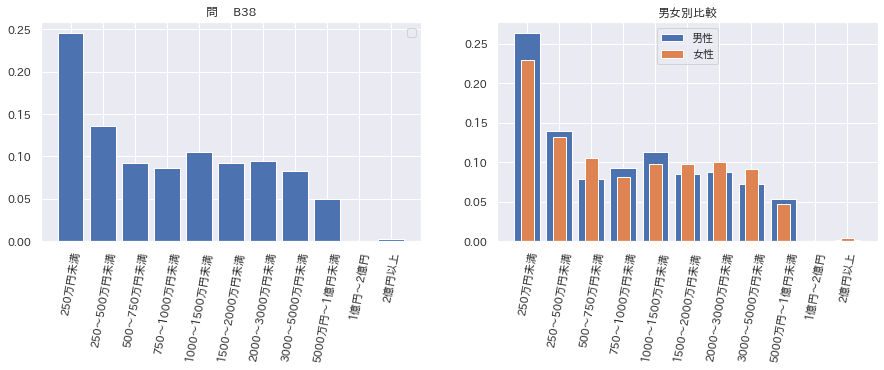

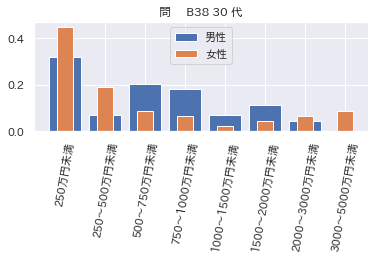

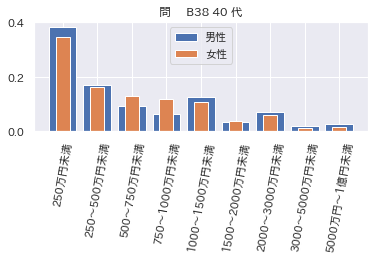

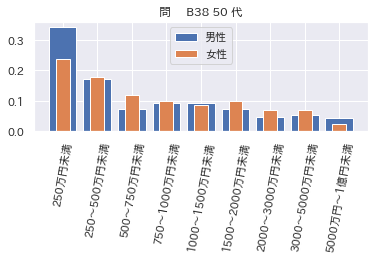

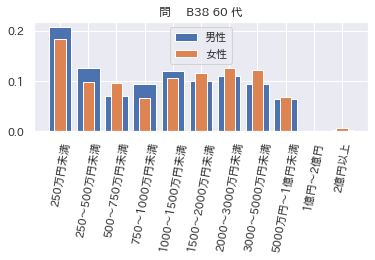

,QB38,男性,女性,30代 男性,30代 女性,40代 男性,40代 女性,50代 男性,50代 女性,60代 男性,60代 女性
250万円未満,0.246,0.264,0.230,0.318,0.447,0.383,0.348,0.341,0.235,0.207,0.183
250～500万円未満,0.136,0.140,0.132,0.068,0.191,0.170,0.163,0.173,0.180,0.126,0.098
500～750万円未満,0.093,0.078,0.106,0.205,0.085,0.092,0.129,0.072,0.118,0.070,0.096
750～1000万円未満,0.087,0.093,0.082,0.182,0.064,0.064,0.118,0.092,0.099,0.093,0.066
1000～1500万円未満,0.105,0.113,0.098,0.068,0.021,0.128,0.107,0.092,0.087,0.120,0.107
1500～2000万円未満,0.092,0.086,0.098,0.114,0.043,0.035,0.039,0.072,0.099,0.099,0.115
2000～3000万円未満,0.095,0.088,0.101,0.045,0.064,0.071,0.062,0.048,0.071,0.109,0.127
3000～5000万円未満,0.083,0.072,0.092,nan,0.085,0.021,0.011,0.052,0.071,0.095,0.122
5000万円～1億円未満,0.050,0.053,0.048,nan,nan,0.028,0.017,0.044,0.025,0.065,0.069
1億円～2億円,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [985]:
pd.options.display.float_format = '{:.3f}'.format # 表示桁

Key=np.sort(data_2020["QB38"].unique())
Option=["250万円未満","250～500万円未満","500～750万円未満","750～1000万円未満","1000～1500万円未満","1500～2000万円未満",
       "2000～3000万円未満","3000～5000万円未満","5000万円～1億円未満","1億円~2億円","2億円以上","無回答"]
Option_A=["250万円未満","250～500万円未満","500～750万円未満","750～1000万円未満","1000～1500万円未満","1500～2000万円未満",
       "2000～3000万円未満","3000～5000万円未満","5000万円～1億円未満","1億円～2億円","2億円以上"]
Label=dict(zip(Key,Option))
性別={1:"男性",2:"女性"}

QB38_summary=None

N=(data_2020["QB38"]!=99).sum()
tmp=data_2020["QB38"].replace(Label).value_counts()[Option_A]/N
QB38_summary= pd.concat([ QB38_summary, tmp],axis=1)

N=(male["QB38"]!=99).sum()
tmp=male["QB38"].replace(Label).value_counts()[Option_A]/N
QB38_summary["男性"]=tmp

N=(female["QB38"]!=99).sum()
tmp=female["QB38"].replace(Label).value_counts()[Option_A]/N
QB38_summary["女性"]=tmp


x=(data_2020["QB38"].replace(Label).value_counts()/(data_2020["QB38"]!=99).sum())[Option_A]

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 2, 1)
ax.bar(x.index ,x)
ax.legend()
plt.title('問　 B38')
plt.xticks(rotation=80)
#plt.rcParams['figure.subplot.bottom'] = 0.1
#plt.savefig('../fig/問_B38_2020.png')
#plt.show()

male=data_2020[data_2020["QB1"]==1]
female=data_2020[data_2020["QB1"]==2]
x=(male["QB38"].replace(Label).value_counts()/(male["QB38"]!=99).sum())[Option_A]
y=(female["QB38"].replace(Label).value_counts()/(female["QB38"]!=99).sum())[Option_A]

ax2 = fig.add_subplot(1, 2, 2)
ax2.bar(x.index ,x,label='男性')
ax2.bar(y.index, y, width=0.4, label='女性')
ax2.legend()
plt.title('男女別比較')
plt.xticks(rotation=80)
plt.rcParams['figure.subplot.bottom'] = 0.5
plt.savefig('../fig/問_B38_2020.png')
plt.show()


for age in sorted(set(data_2020["Age_dummy2"])):
    tmp=male[male["QB38"]!=99]
    male_age=tmp[tmp["Age_dummy2"]==age]
    male_N=len(male_age)
    


    tmp=female[female["QB38"]!=99]
    female_age=tmp[tmp["Age_dummy2"]==age]
    female_N=len(female_age)
    
    x=(male_age["QB38"].replace(Label).value_counts())[Option_A] /male_N
    y=(female_age["QB38"].replace(Label).value_counts())[Option_A] /female_N
    QB38_summary[str(age)+"代 男性"]=x    
    QB38_summary[str(age)+"代 女性"]=y

    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(x.index ,x,label='男性')
    ax.bar(y.index, y, width=0.4, label='女性')
    ax.legend()
    plt.title('問　 B38 ' +str(age) +" 代")
    plt.xticks(rotation=80)
    #plt.ylim(0, 0.45)
    plt.savefig("../fig/問_B38_2020_"+str(age)+"　代.png")
    plt.show()

QB38_summary.to_excel("../fig/QB38_summary.xls",index=True)
display(QB38_summary)
    

# QB39

In [1125]:
pd.options.display.float_format = '{:.0f}'.format # 表示桁
QB39_summary_xls= pd.ExcelWriter("../fig/QB39_summary.xls")    

QB39=["QB39_A-1","QB39_A-2","QB39_A-3","QB39_B-0","QB39_B-1","QB39_B-2","QB39_B-3"]
Result=None
for qb39 in QB39:
    Result= pd.concat([ Result, data_2020[data_2020[qb39]!=99999][qb39].describe()],axis=1)
QB39_summary=Result
QB39_summary.to_excel(QB39_summary_xls,sheet_name= "全体",index=True)

data_2020[data_2020[qb39]!=99999][qb39]

Result=None
for qb39 in QB39:
    tmp= male[male[qb39]!=99999]
    Result= pd.concat([ Result, tmp[qb39].describe()],axis=1)
QB39_male_summary=Result
QB39_male_summary.to_excel(QB39_summary_xls,sheet_name= "男性",index=True)

Result=None
for qb39 in QB39:
    tmp= female[female[qb39]!=99999]
    Result= pd.concat([ Result, tmp[qb39].describe()],axis=1)
QB39_female_summary=Result
QB39_female_summary.to_excel(QB39_summary_xls,sheet_name= "女性",index=True)

# エクセルファイルを保存
QB39_summary_xls.save()    

display(QB39_summary)

,QB39_A-1,QB39_A-2,QB39_A-3,QB39_B-0,QB39_B-1,QB39_B-2,QB39_B-3
count,1977,1971,1973,1964,1932,1928,1927
mean,452,1778,2910,364,443,786,1077
std,1099,3172,4538,316,462,1810,3001
min,0,0,0,10,0,0,0
25%,5,200,200,210,248,300,300
50%,200,1000,1000,300,360,500,500
75%,500,2850,5000,441,500,700,800
max,28000,80000,99998,10000,10000,60000,99998


In [1234]:
pd.options.display.float_format = '{:.3f}'.format # 表示桁
tmp_columns=["QB39_B-0","QB39_B-1","QB39_B-2","QB39_B-3" ,"QB39_A-1","QB39_A-2","QB39_A-3"]
tmp=data_2020[(data_2020[tmp_columns]!=99999).sum(axis=1)==len(tmp_columns)]
tmp["B-1_rate"]=(tmp["QB39_B-1"]-tmp["QB39_B-0"])/2000
tmp["B-2_rate"]=(tmp["QB39_B-2"]-tmp["QB39_B-0"])/10000
tmp["B-3_rate"]=(tmp["QB39_B-3"]-tmp["QB39_B-0"])/20000
tmp["A-1_rate"]=tmp["QB39_A-1"]/2000
tmp["A-2_rate"]=tmp["QB39_A-2"]/10000
tmp["A-3_rate"]=tmp["QB39_A-3"]/20000
tmp["B-1"]=tmp["QB39_B-1"]/tmp["QB39_B-0"]
tmp["B-2"]=tmp["QB39_B-2"]/tmp["QB39_B-0"]
tmp["B-3"]=tmp["QB39_B-3"]/tmp["QB39_B-0"]


Real_QB39=tmp[["QB39_B-0","B-1","B-2","B-3","B-1_rate","B-2_rate","B-3_rate","A-1_rate","A-2_rate","A-3_rate"]].describe()
QB39_summary_xls= pd.ExcelWriter("../fig/QB39_summary2.xls")    
Real_QB39.to_excel(QB39_summary_xls,sheet_name= "実質値",index=True)
# エクセルファイルを保存
QB39_summary_xls.save()    

display(QB39_summary)

/Users/ryo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/ryo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/ryo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,QB39_A-1,QB39_A-2,QB39_A-3,QB39_B-0,QB39_B-1,QB39_B-2,QB39_B-3
count,1977.000,1971.000,1973.000,1964.000,1932.000,1928.000,1927.000
mean,451.573,1777.747,2910.271,363.503,443.392,786.067,1076.958
std,1099.452,3172.480,4537.886,316.160,462.222,1810.030,3000.814
min,0.000,0.000,0.000,10.000,0.000,0.000,0.000
25%,5.000,200.000,200.000,210.000,247.500,300.000,300.000
50%,200.000,1000.000,1000.000,300.000,360.000,500.000,500.000
75%,500.000,2850.000,5000.000,441.000,500.000,700.000,800.000
max,28000.000,80000.000,99998.000,10000.000,10000.000,60000.000,99998.000


# QB26 物価予想

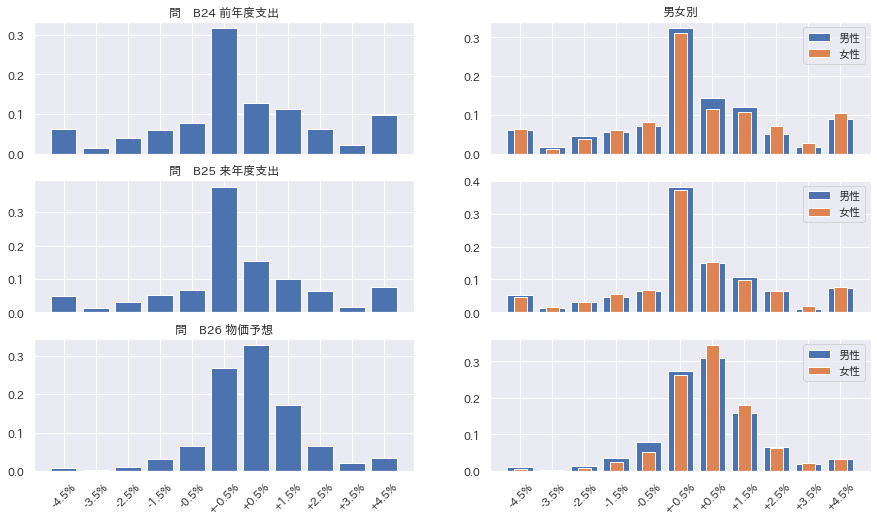

NameError: name 'QB24_26_summary' is not defined

In [1114]:
Key_QB24=np.sort(data_2020["QB25"].unique())
Option_QB24=["-9%","-7%","-5%","-3%","-1%","+-1%",
       "+1%","+3%","+5%","+7%","+9%","無回答"]
Option_QB24_A=["-9%","-7%","-5%","-3%","-1%","+-1%",
       "+1%","+3%","+5%","+7%","+9%"]

Key_QB25=np.sort(data_2020["QB25"].unique())
Option_QB25=["-9%","-7%","-5%","-3%","-1%","+-1%",
       "+1%","+3%","+5%","+7%","+9%","無回答"]
Option_QB25_A=["-9%","-7%","-5%","-3%","-1%","+-1%",
       "+1%","+3%","+5%","+7%","+9%"]

Key_QB26=np.sort(data_2020["QB26"].unique())
Option_QB26=["-4.5%","-3.5%","-2.5%","-1.5%","-0.5%","+-0.5%",
       "+0.5%","+1.5%","+2.5%","+3.5%","+4.5%","無回答"]
Option_QB26_A=["-4.5%","-3.5%","-2.5%","-1.5%","-0.5%","+-0.5%",
       "+0.5%","+1.5%","+2.5%","+3.5%","+4.5%"]

QB24_26_summary_xls= pd.ExcelWriter("../fig/QB24_26_summary.xls")    

Label=dict(zip(Key_QB24,Option_QB24))
tmp=data_2020[data_2020["QB24"]!=99]
QB24=(tmp["QB24"].replace(Label).value_counts()/len(tmp))[Option_QB24_A]
QB24_male=(tmp[tmp["QB1"]==1]["QB24"].replace(Label).value_counts()/len(tmp[tmp["QB1"]==1]))[Option_QB24_A]
QB24_female=(tmp[tmp["QB1"]==2]["QB24"].replace(Label).value_counts()/len(tmp[tmp["QB1"]==2]))[Option_QB24_A]
QB24=pd.concat([QB24,QB24_male,QB24_female],axis=1)
QB24.columns=["全体","男性","女性"]
QB24.to_excel(QB24_26_summary_xls,sheet_name= "QB24",index=True)

Label=dict(zip(Key_QB25,Option_QB25))
tmp=data_2020[data_2020["QB25"]!=99]
QB25=(tmp["QB25"].replace(Label).value_counts()/len(tmp))[Option_QB25_A]
QB25_male=(tmp[tmp["QB1"]==1]["QB25"].replace(Label).value_counts()/len(tmp[tmp["QB1"]==1]))[Option_QB25_A]
QB25_female=(tmp[tmp["QB1"]==2]["QB25"].replace(Label).value_counts()/len(tmp[tmp["QB1"]==2]))[Option_QB25_A]
QB25=pd.concat([QB25,QB25_male,QB25_female],axis=1)
QB25.columns=["全体","男性","女性"]
QB25.to_excel(QB24_26_summary_xls,sheet_name= "QB25",index=True)


Label=dict(zip(Key_QB26,Option_QB26))
tmp=data_2020[data_2020["QB26"]!=99]
QB26=(tmp["QB26"].replace(Label).value_counts()/len(tmp))[Option_QB26_A]
QB26_male=(tmp[tmp["QB1"]==1]["QB26"].replace(Label).value_counts()/len(tmp[tmp["QB1"]==1]))[Option_QB26_A]
QB26_female=(tmp[tmp["QB1"]==2]["QB26"].replace(Label).value_counts()/len(tmp[tmp["QB1"]==2]))[Option_QB26_A]
QB26=pd.concat([QB26,QB26_male,QB26_female],axis=1)
QB26.columns=["全体","男性","女性"]
QB26.to_excel(QB24_26_summary_xls,sheet_name= "QB26",index=True)

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(3, 2, 1)
ax.bar(QB24.index ,QB24["全体"])
plt.title('問　B24 前年度支出')
ax.tick_params(labelbottom=False)

ax = fig.add_subplot(3, 2, 2)
ax.bar(QB24.index ,QB24["男性"],label='男性')
ax.bar(QB24.index ,QB24["女性"], width=0.4, label='女性')
plt.title('男女別')
ax.legend()
ax.tick_params(labelbottom=False)



ax = fig.add_subplot(3, 2, 3)
ax.bar(QB25.index ,QB25["全体"])
plt.title('問　B25 来年度支出')
ax.tick_params(labelbottom=False)
ax = fig.add_subplot(3, 2, 4)
ax.bar(QB25.index ,QB25["男性"],label='男性')
ax.bar(QB25.index ,QB25["女性"], width=0.4, label='女性')
ax.legend()
plt.xticks(rotation=80)
ax.tick_params(labelbottom=False)


ax = fig.add_subplot(3, 2, 5)
ax.bar(QB26.index ,QB26["全体"])
plt.title('問　B26 物価予想')
plt.xticks(rotation=45)
ax = fig.add_subplot(3, 2, 6)
ax.bar(QB26.index ,QB26["男性"],label='男性')
ax.bar(QB26.index ,QB26["女性"], width=0.4, label='女性')
ax.legend()
plt.xticks(rotation=45)

plt.rcParams['figure.subplot.bottom'] = 0.1
plt.savefig('../fig/問_B24_26_2020.png')
plt.show()

# エクセルファイルを保存
QB24_26_summary_xls.save()    


# QB 34 金融資産残高

No handles with labels found to put in legend.


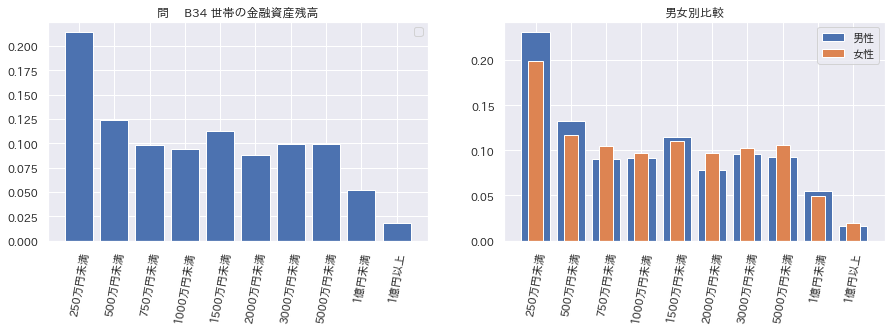

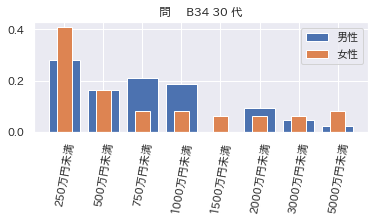

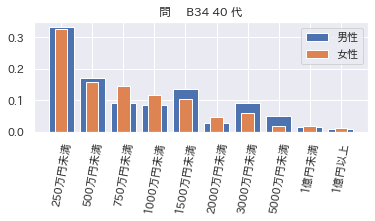

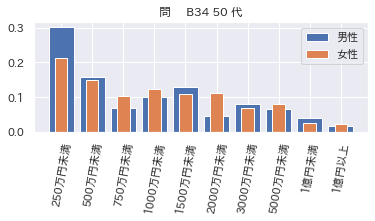

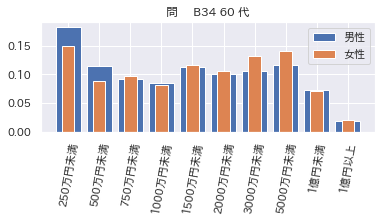

,QB34,男性,女性,30代 男性,30代 女性,40代 男性,40代 女性,50代 男性,50代 女性,60代 男性,60代 女性
250万円未満,0.214,0.231,0.199,0.279,0.408,0.331,0.326,0.301,0.212,0.182,0.148
500万円未満,0.124,0.133,0.117,0.163,0.163,0.169,0.157,0.157,0.150,0.115,0.088
750万円未満,0.098,0.091,0.105,0.209,0.082,0.092,0.145,0.068,0.104,0.092,0.097
1000万円未満,0.094,0.092,0.097,0.186,0.082,0.085,0.116,0.100,0.123,0.084,0.081
1500万円未満,0.112,0.115,0.110,nan,0.061,0.134,0.105,0.129,0.107,0.113,0.116
2000万円未満,0.088,0.078,0.097,0.093,0.061,0.028,0.047,0.044,0.110,0.100,0.105
3000万円未満,0.099,0.096,0.102,0.047,0.061,0.092,0.058,0.080,0.067,0.106,0.132
5000万円未満,0.099,0.093,0.105,0.023,0.082,0.049,0.017,0.064,0.080,0.116,0.140
1億円未満,0.052,0.055,0.049,nan,nan,0.014,0.017,0.040,0.025,0.073,0.071
1億円以上,0.018,0.016,0.019,nan,nan,0.007,0.012,0.016,0.021,0.019,0.021


In [1235]:
pd.options.display.float_format = '{:.3f}'.format # 表示桁

Key=np.sort(data_2020["QB34"].unique())
Option=["250万円未満","500万円未満","750万円未満","1000万円未満","1500万円未満","2000万円未満",
       "3000万円未満","5000万円未満","1億円未満","1億円以上","無回答"]
Option_A=["250万円未満","500万円未満","750万円未満","1000万円未満","1500万円未満","2000万円未満",
       "3000万円未満","5000万円未満","1億円未満","1億円以上"]
Label=dict(zip(Key,Option))

QB34_summary=None

N=(data_2020["QB34"]!=99).sum()
tmp=data_2020["QB34"].replace(Label).value_counts()[Option_A]/N
QB34_summary= pd.concat([ QB34_summary, tmp],axis=1)

N=(male["QB34"]!=99).sum()
tmp=male["QB34"].replace(Label).value_counts()[Option_A]/N
QB34_summary["男性"]=tmp

N=(female["QB34"]!=99).sum()
tmp=female["QB34"].replace(Label).value_counts()[Option_A]/N
QB34_summary["女性"]=tmp


x=(data_2020["QB34"].replace(Label).value_counts()/(data_2020["QB34"]!=99).sum())[Option_A]

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 2, 1)
ax.bar(x.index ,x)
ax.legend()
plt.title('問　 B34 世帯の金融資産残高')
plt.xticks(rotation=80)
#plt.rcParams['figure.subplot.bottom'] = 0.1
#plt.savefig('../fig/問_B38_2020.png')
#plt.show()

male=data_2020[data_2020["QB1"]==1]
female=data_2020[data_2020["QB1"]==2]
x=(male["QB34"].replace(Label).value_counts()/(male["QB34"]!=99).sum())[Option_A]
y=(female["QB34"].replace(Label).value_counts()/(female["QB34"]!=99).sum())[Option_A]

ax2 = fig.add_subplot(1, 2, 2)
ax2.bar(x.index ,x,label='男性')
ax2.bar(y.index, y, width=0.4, label='女性')
ax2.legend()
plt.title('男女別比較')
plt.xticks(rotation=80)
plt.rcParams['figure.subplot.bottom'] = 0.5
plt.savefig('../fig/問_B34_2020.png')
plt.show()


for age in sorted(set(data_2020["Age_dummy2"])):
    
    tmp=male[male["QB34"]!=99]
    male_age=tmp[tmp["Age_dummy2"]==age]
    male_N=len(male_age)
    
    tmp=female[female["QB34"]!=99]
    female_age=tmp[tmp["Age_dummy2"]==age]
    female_N=len(female_age)
    
    x=(male_age["QB34"].replace(Label).value_counts())[Option_A] /male_N
    y=(female_age["QB34"].replace(Label).value_counts())[Option_A] /female_N
    QB34_summary[str(age)+"代 男性"]=x    
    QB34_summary[str(age)+"代 女性"]=y

    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(x.index ,x,label='男性')
    ax.bar(y.index, y, width=0.4, label='女性')
    ax.legend()
    plt.title('問　 B34 ' +str(age) +" 代")
    plt.xticks(rotation=80)
    #plt.ylim(0, 0.45)
    plt.savefig("../fig/問_B34_2020_"+str(age)+"　代.png")
    plt.show()

QB34_summary.to_excel("../fig/QB34_summary.xls",index=True)
display(QB34_summary)


# 問　35

In [1309]:
tmp_columns=["QB35#01","QB35#02","QB35#03","QB35#04","QB35#05","QB35#06","QB35#07","QB35#08","QB35#09","QB35#10",
            "QB35#11","QB35#12","QB35#13","QB35#14"]

tmp=data_2020[(data_2020[tmp_columns]!=9).sum(axis=1)==len(tmp_columns) ]
QB35=pd.concat([tmp[tmp_columns].sum(axis=0)/len(tmp),
                tmp[tmp["QB1"]==1][tmp_columns].sum(axis=0)/len(tmp[tmp["QB1"]==1]),
                tmp[tmp["QB1"]==2][tmp_columns].sum(axis=0)/len(tmp[tmp["QB1"]==2]) ],axis=1)
QB35.columns=["全体","男性", "女性"]
QB35.index=["銀行預金","郵便貯金", "生命保険", "株式", "投資信託", "外貨預金", "先物・オプション", "日本の国債", "外国債", "個人年金","企業年金", "現金貯金", "その他", "金融資産は持っていない"]
display(QB35)

QB35_summary_xls= pd.ExcelWriter("../fig/QB35_summary.xls")    
QB35.to_excel(QB35_summary_xls,index=True)
# エクセルファイルを保存
QB35_summary_xls.save()    


QB35_1=None
tmp=data_2020[(data_2020["QB35_1"]!=999)&((data_2020["QB35_1"]!=888))]
QB35_1=tmp["QB35_1"].describe()
tmp=data_2020[(data_2020["QB35_1"]!=888)&(data_2020["QB35_1"]!=999)&(data_2020["QB1"]==1)]
QB35_1=pd.concat([QB35_1,tmp["QB35_1"].describe()],axis=1)
tmp=data_2020[(data_2020["QB35_1"]!=888)&(data_2020["QB35_1"]!=999)&(data_2020["QB1"]==2)]
QB35_1=pd.concat([QB35_1,tmp["QB35_1"].describe()],axis=1)
QB35_1.columns=["全体","男性", "女性"]
display(QB35_1)



QB35_1_summary_xls= pd.ExcelWriter("../fig/QB35_1_summary.xls")    
QB35_1.to_excel(QB35_1_summary_xls,index=True)
# エクセルファイルを保存
QB35_1_summary_xls.save()    


,全体,男性,女性
銀行預金,0.918,0.923,0.913
郵便貯金,0.596,0.543,0.640
生命保険,0.602,0.571,0.627
株式,0.208,0.253,0.170
投資信託,0.178,0.185,0.172
外貨預金,0.054,0.052,0.055
先物・オプション,0.003,0.005,0.002
日本の国債,0.035,0.038,0.031
外国債,0.012,0.014,0.010
個人年金,0.264,0.230,0.292


,全体,男性,女性
count,2138.000,1018.000,1120.000
mean,11.700,12.708,10.784
std,21.003,21.488,20.518
min,0.000,0.000,0.000
25%,0.000,0.000,0.000
50%,0.000,0.000,0.000
75%,10.000,20.000,10.000
max,100.000,100.000,100.000



# 問　36

In [1413]:
dict(a=2,)["a"]

2

In [ ]:
class Kanagata:
    #コンストラクタ
    def __init__(self, name):
        self.name = name
    #メソッド
    def make(self):
        print("味は"+self.name+"です")
        

In [1535]:
###
import datetime
dt_now = datetime.datetime.now()



'2021/6/11/13:13'